# Basic lgb code
- titanicでlgb
- テーブルデータの基本の基本

## import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

## load data

In [2]:
data = sns.load_dataset('titanic')

In [3]:

data.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

## preprocess
- カテゴリ変数を簡単に処理する
- nullは'null'カテゴリにする
- 他の処理はhttps://qiita.com/ground0state/items/f516b97c7a8641e474c4 とか参照

In [4]:

def get_categorical_cols(df, fill_null=True) -> pd.DataFrame():
    
    '''
    define categorical cols
    '''

    categorical_cols = [] 

    for col in data.columns:
        if data[col].dtypes not in ['float', 'int', 'bool']:
            categorical_cols.append(col)
            data[col] = data[col].astype('object')

    return categorical_cols


# label_encoding categorical cols
def label_encoding(df, fill_null = True) -> pd.DataFrame():
    
    for col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].values)
        
    return df


data = data.dropna()
categorical_cols = get_categorical_cols(data)
data[categorical_cols] = label_encoding(data[categorical_cols])


## Modeling

In [5]:
target = 'survived'
features = [col for col in data.columns if col not in [target, 'alive']]
print('features:', features)

# divide train and test
train_index = int(len(data) * 0.8)
train = data[:train_index]
test = data[train_index:].reset_index(drop=True)

# define target and feature
Y = train[target]
X = train[features]


features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone']


In [6]:

fold_num = 3
kf = KFold(n_splits=fold_num)
val_pred = np.zeros(len(X))
pred = np.zeros(len(test))
importance_list = np.zeros(len(features))

for train_index, val_index in kf.split(X, Y):
    X_train = X.iloc[train_index]
    X_val = X.iloc[val_index]
    y_train = Y.iloc[train_index]
    y_val = Y.iloc[val_index]

    model = lgb.LGBMClassifier(objective='binary',
                             metric='auc',
                             num_leaves=300,
                             learning_rate=0.03,
                             random_seed=1,
                             max_depth=4
                            )

    model.fit(X_train, y_train,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds=20,
            verbose=10)

    importance_list += model.feature_importances_
    val_pred[val_index] = model.predict_proba(X_val[features], num_iteration=model.best_iteration_)[:,1]

    # pred
    pred += model.predict_proba(test[features], num_iteration=model.best_iteration_)[:,1] / fold_num

importance = importance_list / fold_num
feature_imp = pd.DataFrame(sorted(zip(importance, features)), columns=['Value','Feature'])
    

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.841973
[20]	valid_0's auc: 0.841973
Early stopping, best iteration is:
[5]	valid_0's auc: 0.841973
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.859341
[20]	valid_0's auc: 0.859341
Early stopping, best iteration is:
[1]	valid_0's auc: 0.87033
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.804396
[20]	valid_0's auc: 0.804396
[30]	valid_0's auc: 0.812088
[40]	valid_0's auc: 0.80989
Early stopping, best iteration is:
[23]	valid_0's auc: 0.812088


## Visualise importance

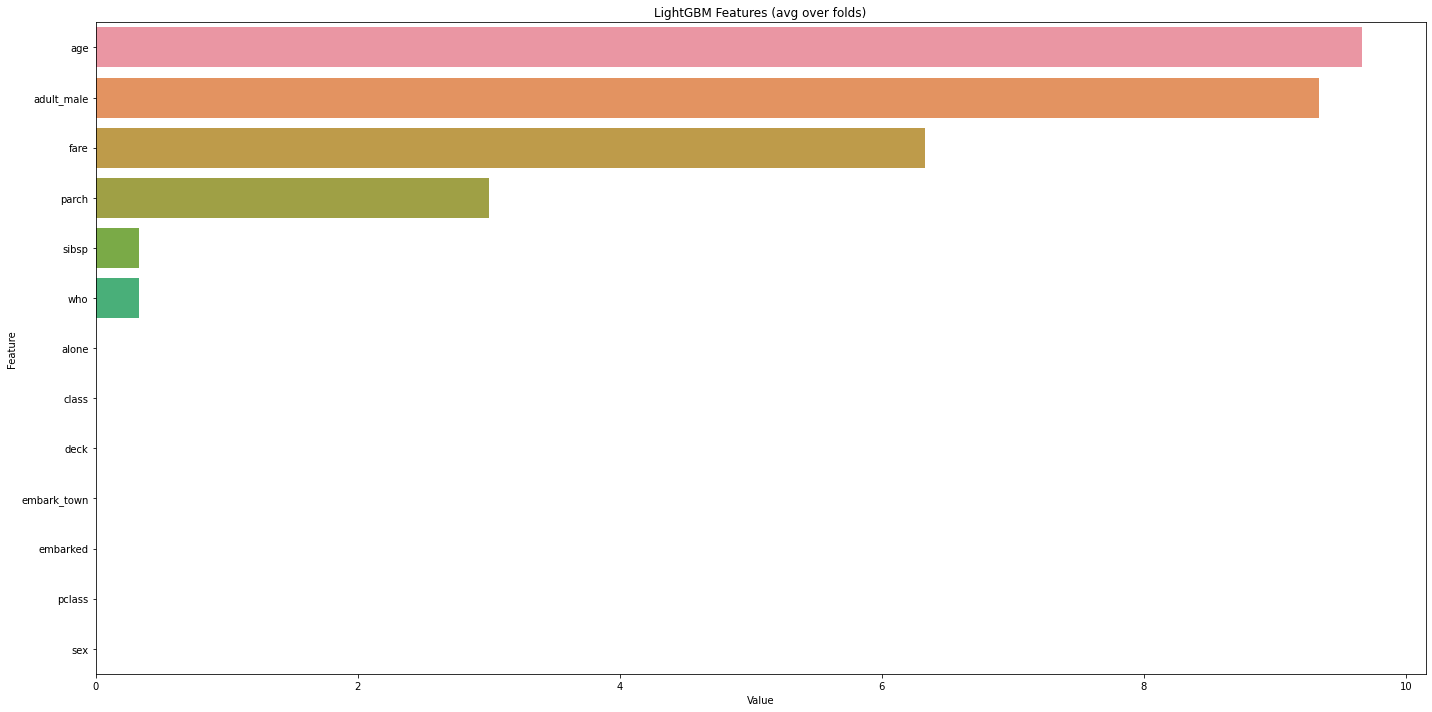

In [7]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

## pred test data

In [8]:
test['pred'] = pred
test.tail(20)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,pred
17,1,1,0,43.0,0,1,211.3375,2,0,2,False,1,2,1,False,0.724368
18,1,1,0,17.0,1,0,57.0000,2,0,2,False,1,2,1,False,0.721584
19,0,1,1,29.0,0,0,30.0000,2,0,1,True,3,2,0,True,0.624981
20,0,1,1,46.0,0,0,79.2000,0,0,1,True,1,0,0,True,0.559651
21,1,1,0,49.0,0,0,25.9292,2,0,2,False,3,2,1,True,0.722568
22,1,1,1,11.0,1,2,120.0000,2,0,0,False,1,2,1,False,0.721081
23,0,1,1,39.0,0,0,0.0000,2,0,1,True,0,2,0,True,0.611661
24,1,1,0,33.0,1,0,53.1000,2,0,2,False,4,2,1,False,0.722568
25,1,1,0,52.0,1,1,93.5000,2,0,2,False,1,2,1,False,0.724368
26,1,3,0,27.0,0,1,12.4750,2,2,2,False,4,2,1,False,0.713187


enjoy!